In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [ ]:
# Standard imports for data manipulation and visualization
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import copy
import numpy as np
import math

# Statistical distributions and functions
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate

# Data handling
import pandas as pd

# Time series modeling
import prophet

# Financial data
import yfinance as yf

# Optimization
from scipy.optimize import brentq, fsolve

# Vine copula library
import pyvinecopulib as pv

# Lesson 9: Introduction to Vine Copulas

In this lesson, we introduce **vine copulas**, a flexible framework for modeling high-dimensional dependencies. While standard multivariate copulas (like the Gaussian or Student-t copula) impose symmetric dependence structures, vine copulas allow us to build complex multivariate distributions by combining bivariate copulas in a hierarchical manner.

**Learning Objectives:**
1. Review Sklar's Theorem for multivariate distributions
2. Understand how joint densities decompose into conditional distributions
3. Learn the relationship between conditional densities and copulas
4. Construct vine copulas (C-Vine structure)
5. Apply vine copulas to real financial data

---

## 1. Review: Sklar's Theorem

Recall that Sklar's Theorem states that any multivariate distribution can be expressed in terms of its marginals and a copula:

$$ H(x_1, x_2, \ldots, x_d) = C(F_1(x_1), F_2(x_2), \ldots, F_d(x_d)) $$

And conversely:

$$ C(u_1, u_2, \ldots, u_d) = H(F_1^{-1}(u_1), F_2^{-1}(u_2), \ldots, F_d^{-1}(u_d)) $$

---

## 2. Decomposition of Joint Densities

The key insight behind vine copulas is that we can decompose any multivariate density into a product of conditional densities. This decomposition is not unique - there are many valid orderings.

### 2.1 Two-Dimensional Case

For two variables, the joint density can be written as:

$$ 
\begin{align}
    f(x_1, x_2) &= f(x_1 | x_2) \cdot f(x_2) \\
                &= f(x_2 | x_1) \cdot f(x_1) 
\end{align}
$$

### 2.2 Three-Dimensional Case

For three variables, there are multiple valid decompositions. Each ordering corresponds to a different **vine structure**:

$$ 
\begin{align}
    f(x_1, x_2, x_3) &= f_{1|2,3}(x_1|x_2,x_3) \cdot f_{2|3}(x_2|x_3) \cdot f_3(x_3) \\
                     &= f_{1|2,3}(x_1|x_2,x_3) \cdot f_{3|2}(x_3|x_2) \cdot f_2(x_2) \\
                     &= f_{2|1,3}(x_2|x_1,x_3) \cdot f_{1|3}(x_1|x_3) \cdot f_3(x_3) \\
                     &= f_{2|1,3}(x_2|x_1,x_3) \cdot f_{3|1}(x_3|x_1) \cdot f_1(x_1) \\
                     &= f_{3|1,2}(x_3|x_1,x_2) \cdot f_{1|2}(x_1|x_2) \cdot f_2(x_2) \\
                     &= f_{3|1,2}(x_3|x_1,x_2) \cdot f_{2|1}(x_2|x_1) \cdot f_1(x_1)
\end{align}
$$

---

## 3. Relationship Between Conditional Densities and Copulas

A key result connects conditional densities to copula densities. For the bivariate case:

$$ f_{1|2}(x_1|x_2) = \frac{f(x_1,x_2)}{f_2(x_2)} = c_{1,2}(F_1(x_1), F_2(x_2)) \cdot f_1(x_1) $$

This extends to higher-order conditionals. For example:

$$ f_{1|2,3}(x_1|x_2, x_3) = \frac{f(x_1,x_2|x_3)}{f_{2|3}(x_2|x_3)} = c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3)) \cdot f_{1|3}(x_1|x_3) $$

Here, $c_{1,2|3}$ is a **conditional copula density** that captures the dependence between $X_1$ and $X_2$ given $X_3$.

---

## 4. Constructing a Vine Copula

By combining the density decomposition with the copula representation of conditional densities, we can express the joint density entirely in terms of marginal densities and bivariate copulas:

$$ 
\begin{align}
    f(x_1,x_2,x_3) &= f_{1|2,3}(x_1|x_2,x_3) \cdot f_{2|3}(x_2|x_3) \cdot f_3(x_3) \\ 
                   &= \left[c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3)) \cdot f_{1|3}(x_1|x_3)\right] \times \left[c_{2,3}(F_2(x_2), F_3(x_3)) \cdot f_2(x_2)\right] \times f_3(x_3) \\
                   &= \left[c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3)) \cdot c_{1,3}(F_1(x_1), F_3(x_3)) \cdot f_1(x_1)\right] \times \left[c_{2,3}(F_2(x_2), F_3(x_3)) \cdot f_2(x_2)\right] \times f_3(x_3)
\end{align}
$$

Rearranging, we obtain the **vine copula decomposition**:

$$ 
f(x_1,x_2,x_3) = \underbrace{f_1(x_1) \cdot f_2(x_2) \cdot f_3(x_3)}_{\text{Marginal densities}} \times \underbrace{c_{1,3}(F_1(x_1),F_3(x_3)) \times c_{2,3}(F_2(x_2),F_3(x_3))}_{\text{Tree 1: Unconditional pair-copulas}} \times \underbrace{c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3))}_{\text{Tree 2: Conditional pair-copula}}
$$

This is the essence of a **C-Vine (Canonical Vine)** copula, where one variable (the "center" node) is connected to all others in the first tree.

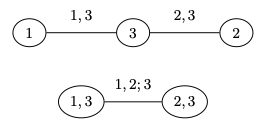

In [3]:
display.Image("vine_example.png")

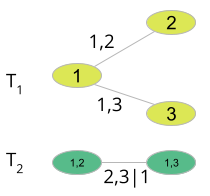

In [4]:
display.Image("cvine_3vars.png")

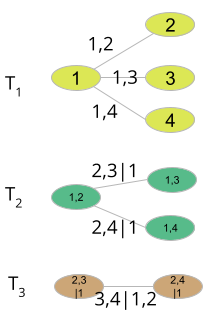

In [5]:
display.Image("cvine_4vars.png")

---

## 5. Practical Example: Cryptocurrency Returns

Let's apply vine copulas to model the joint distribution of returns for three cryptocurrencies:
- **BTC** (Bitcoin) - The largest cryptocurrency by market cap
- **ETH** (Ethereum) - The second largest, known for smart contracts
- **FIL** (Filecoin) - A smaller altcoin for decentralized storage

**Our approach:**
1. Download historical price data using `yfinance`
2. Compute log returns
3. Fit Prophet models to capture time-series patterns and extract residuals
4. Fit a C-Vine copula to the residuals using `pyvinecopulib`
5. Simulate from the fitted copula

### 5.1 Vine Structure Visualization

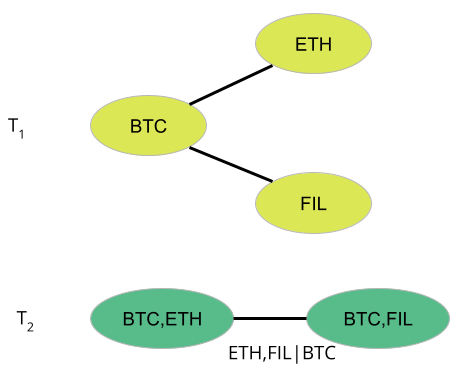

In [6]:
display.Image("crypto_vine_example.png")

In [ ]:
### 5.2 Download Cryptocurrency Data

# Define the cryptocurrency tickers
tickers = ['BTC-USD', 'ETH-USD', 'FIL-USD']

# Download historical price data from Yahoo Finance
data = yf.download(' '.join(tickers), start="2021-01-01", end="2023-12-31")

In [ ]:
# Extract adjusted closing prices
close_prices = data['Adj Close']

# Compute log returns: log(1 + r) where r is the simple return
# This is mathematically equivalent to log(P_t / P_{t-1})
returns_data = np.log1p(close_prices.pct_change())
returns_data = returns_data.reset_index().rename(columns={'Date': 'ds'})
returns_data['ds'] = pd.to_datetime(returns_data['ds']).dt.tz_localize(None)

# Visualize prices and returns
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
for tick in tickers:
    plt.plot(close_prices[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Closing Price (Log Scale)')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
for tick in tickers:
    plt.plot(returns_data['ds'], returns_data[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Log Returns')

plt.tight_layout()

In [ ]:
### 5.3 Fit Time Series Models and Extract Residuals

# We use Facebook Prophet to capture any seasonal/trend patterns in returns.
# The residuals (what Prophet cannot explain) will be modeled with a copula.

tick2data = {}
tick2model = {}

for tick in tickers:
    # Initialize Prophet model (default settings)
    m = prophet.Prophet()
    
    # Prepare data in Prophet's expected format
    df = returns_data[['ds', tick]].rename(columns={tick: 'y'})
    m.fit(df)
    
    # Generate in-sample predictions
    df_forecast = m.predict()
    df = pd.merge(df, df_forecast, on='ds')
    
    # Compute residuals: actual - predicted
    df['residual'] = df['y'] - df['yhat']

    tick2data[tick] = df
    tick2model[tick] = m

In [ ]:
# Visualize the residuals and their pairwise relationships
plt.figure(figsize=(9,4))

# Plot residuals over time
plt.subplot(1,3,1)
for tick in tickers:
    df = tick2data[tick]
    plt.plot(df['ds'], df['residual'], label=tick)
plt.xticks(rotation=60)
plt.legend()
plt.title('Model Prediction Residuals')

# BTC will be the center node in our C-Vine
center_tick = 'BTC-USD'
remaining_tickers = copy.copy(tickers)
remaining_tickers.remove(center_tick)

# Scatter plot: BTC vs ETH residuals
plt.subplot(1,3,2)
plt.scatter(tick2data[center_tick]['residual'], tick2data['ETH-USD']['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel('ETH-USD')
plt.title('BTC vs ETH Residuals')

# Scatter plot: BTC vs FIL residuals
plt.subplot(1,3,3)
plt.scatter(tick2data[center_tick]['residual'], tick2data['FIL-USD']['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel('FIL-USD')
plt.title('BTC vs FIL Residuals')

plt.tight_layout()

In [ ]:
### 5.4 Transform to Pseudo-Observations

# Create a DataFrame of residuals
X = pd.DataFrame()
X['btc_residual'] = tick2data['BTC-USD']['residual'] 
X['eth_residual'] = tick2data['ETH-USD']['residual'] 
X['fil_residual'] = tick2data['FIL-USD']['residual']

# Convert to pseudo-observations (empirical CDF transform to [0,1])
# This is the probability integral transform using the empirical distribution
U = pv.to_pseudo_obs(X)

In [ ]:
# Visualize pairwise pseudo-observations
# These should show the dependence structure without the effect of marginals
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.xlabel('U (BTC)')
plt.ylabel('U (ETH)')
plt.title('BTC vs ETH')

plt.subplot(1,3,2)
plt.scatter(U[:,0], U[:,2], alpha=0.5)
plt.xlabel('U (BTC)')
plt.ylabel('U (FIL)')
plt.title('BTC vs FIL')

plt.subplot(1,3,3)
plt.scatter(U[:,1], U[:,2], alpha=0.5)
plt.xlabel('U (ETH)')
plt.ylabel('U (FIL)')
plt.title('ETH vs FIL')

plt.tight_layout()

In [ ]:
### 5.5 Fit the C-Vine Copula

# Fit a C-Vine copula with BTC as the center node
# Structure [3,2,1] means: variable 3 (FIL) is at top, then 2 (ETH), then 1 (BTC)
# In a C-Vine, the first variable in each tree is the "center" node
cop = pv.Vinecop(data=U, 
                 structure=pv.CVineStructure([3,2,1]))

In [ ]:
# Display the fitted vine copula structure
# TLL = Transformation Local Likelihood (nonparametric kernel estimator)
print("Fitted Vine Copula Structure:")
print(cop)

In [ ]:
### 5.6 Simulate from the Copula

# Number of simulations
n_sim = 500

# Simulate from the fitted copula (returns values in [0,1]^3)
u_sim = cop.simulate(n_sim, seeds=[1, 2, 3])

# Transform back to the original scale using empirical quantiles
x = X.values
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(3)])

In [ ]:
# Compare simulated data with actual residuals
plt.figure(figsize=(8,4))

center_tick = 'BTC-USD'

# BTC vs ETH comparison
plt.subplot(1,2,1)
plt.scatter(tick2data[center_tick]['residual'], tick2data['ETH-USD']['residual'], 
            alpha=0.4, label='Actual Residuals')
plt.scatter(x_sim[0,:], x_sim[1,:], alpha=0.4, label='Copula Simulation')
plt.xlabel('BTC Residual')
plt.ylabel('ETH Residual')
plt.title('BTC vs ETH')
plt.legend()

# BTC vs FIL comparison (FIXED: was incorrectly using x_sim[1] instead of x_sim[2])
plt.subplot(1,2,2)
plt.scatter(tick2data[center_tick]['residual'], tick2data['FIL-USD']['residual'], 
            alpha=0.4, label='Actual Residuals')
plt.scatter(x_sim[0,:], x_sim[2,:], alpha=0.4, label='Copula Simulation')
plt.xlabel('BTC Residual')
plt.ylabel('FIL Residual')
plt.title('BTC vs FIL')

plt.tight_layout()